# Convolutional Neural Networks 

## Importing

Deze code zorgt ervoor dat TensorFlow GPU-geheugen efficiënt gebruikt door geheugen dynamisch toe te wijzen. Standaard reserveert TensorFlow al het GPU-geheugen bij het opstarten. Met `set_memory_growth(gpu, True)` wordt geheugen alleen toegewezen wanneer nodig, waardoor geheugenverspilling voorkomen wordt en het trainen van modellen soepeler en stabieler verloopt. Dit voorkomt problemen zoals geheugenfouten en verhoogt de flexibiliteit bij het uitvoeren van meerdere processen tegelijk op dezelfde GPU.


In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


Download de cifar 10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Normalisatie
Deze stap normaliseert de pixelwaarden van de afbeeldingen uit de CIFAR-10 dataset door ze te schalen naar een bereik tussen 0 en 1 (origineel van 0-255). Hierdoor kan het neurale netwerk sneller, stabieler en efficiënter trainen, omdat alle invoerwaarden vergelijkbaar zijn en het model hierdoor makkelijker patronen kan herkennen. Dit helpt de prestaties en nauwkeurigheid van het netwerk aanzienlijk te verbeteren.

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Netwerk opbouwen
Dit convolutionele neurale netwerk bestaat uit twee convolutionele blokken. In het eerste blok worden 32 filters gebruikt, en in het tweede blok worden 64 filters toegepast om kenmerken uit de CIFAR-10 afbeeldingen te extraheren. Elk convolutieblok bevat twee convolutielagen met activatiefunctie ReLU om niet-lineariteit toe te voegen, gevolgd door Batch Normalization om de training stabieler en sneller te laten verlopen door tussenresultaten te normaliseren. Daarna volgt MaxPooling om de afbeeldingen te verkleinen en Dropout om overfitting te verminderen door neuronen willekeurig uit te schakelen.

Vervolgens worden alle kenmerken samengevoegd in een volledig verbonden (Dense) laag van 512 neuronen, opnieuw met Dropout (50%) om verdere overfitting te voorkomen. De laatste laag bevat 10 neuronen met een softmax-functie, waarmee het netwerk uiteindelijk bepaalt tot welke van de 10 CIFAR-10-klassen een afbeelding behoort.

In [5]:
model = Sequential()
# Eerste conv-blok
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Tweede conv-blok
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense lagen
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## Compilen en trainen 
Het CNN-model wordt gecompileerd en getraind met behulp van de Adam-optimizer, die zorgt voor efficiënte en snelle optimalisatie van het netwerk. De gekozen loss-functie, *sparse categorical crossentropy*, is geschikt voor het classificeren van afbeeldingen in meerdere klassen, zoals bij CIFAR-10. De accuracy geeft inzicht in hoe goed het model presteert. Tijdens het trainen worden batches van 32 afbeeldingen gebruikt, met 50 epochs voor voldoende leervermogen. Door 10% van de trainingsdata voor validatie te reserveren, kan gecontroleerd worden of het model generaliseert en niet overfit.

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
1407/1407 [==============================] - 46s 32ms/step - loss: 1.6425 - accuracy: 0.4284 - val_loss: 1.2137 - val_accuracy: 0.5714
Epoch 2/50
1407/1407 [==============================] - 48s 34ms/step - loss: 1.1961 - accuracy: 0.5802 - val_loss: 1.0030 - val_accuracy: 0.6674
Epoch 3/50
1407/1407 [==============================] - 49s 35ms/step - loss: 1.0185 - accuracy: 0.6475 - val_loss: 0.8744 - val_accuracy: 0.7012
Epoch 4/50
1407/1407 [==============================] - 48s 34ms/step - loss: 0.9155 - accuracy: 0.6852 - val_loss: 0.8311 - val_accuracy: 0.7114
Epoch 5/50
1407/1407 [==============================] - 100s 71ms/step - loss: 0.8305 - accuracy: 0.7138 - val_loss: 0.7294 - val_accuracy: 0.7496
Epoch 6/50
1407/1407 [==============================] - 46s 33ms/step - loss: 0.7660 - accuracy: 0.7337 - val_loss: 0.9295 - val_accuracy: 0.7070
Epoch 7/50
1407/1407 [==============================] - 48s 34ms/step - loss: 0.6975 - accuracy: 0.7602 - val_loss: 0.6372 

## Plotting
Deze code maakt grafieken van de trainings- en validatiemetrieken (loss en accuracy) per epoch, om inzicht te krijgen in hoe het model tijdens de training presteert:

- **Loss-grafiek**: toont hoe snel en effectief het model leert. Een lagere loss betekent beter leren. Door trainings- en validatieloss samen te bekijken, zie je of er sprake is van overfitting (wanneer validatieloss niet meer afneemt terwijl trainingsloss wel blijft dalen).

- **Accuracy-grafiek**: laat zien hoe goed het model afbeeldingen correct voorspelt. Een hogere accuracy duidt op betere prestaties. Het vergelijken van trainings- en validatie-accuracy geeft een indicatie of het model goed generaliseert naar ongeziene data.


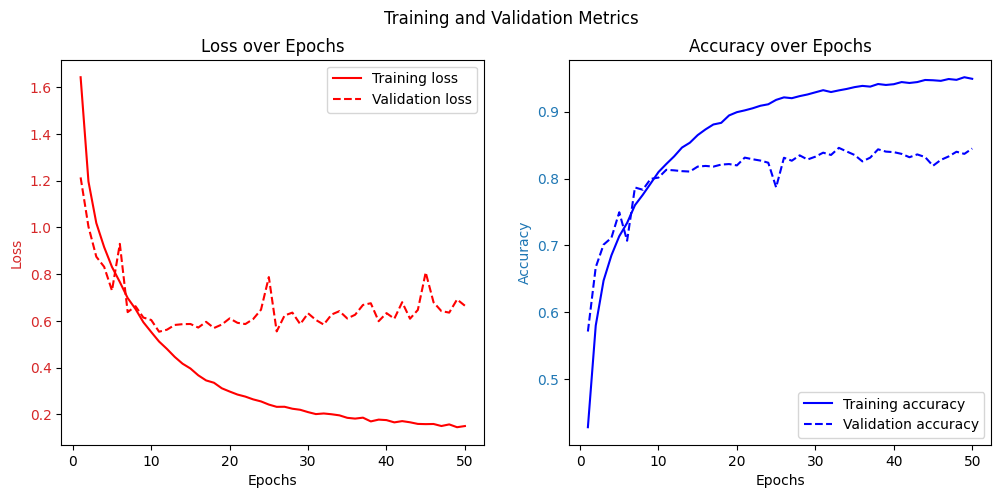

In [7]:
# Get history data
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Create two subplots in one row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss on the first subplot
ax1.plot(epochs, loss, 'r-', label='Training loss')
ax1.plot(epochs, val_loss, 'r--', label='Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend()
ax1.set_title('Loss over Epochs')

# Plot Accuracy on the second subplot
ax2.plot(epochs, accuracy, 'b-', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'b--', label='Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()
ax2.set_title('Accuracy over Epochs')

plt.suptitle('Training and Validation Metrics')
plt.show()

Deze code maakt een **confusion matrix** om te visualiseren hoe goed het CNN-model afbeeldingen classificeert op de testset.

313/313 [==============================] - 3s 8ms/step


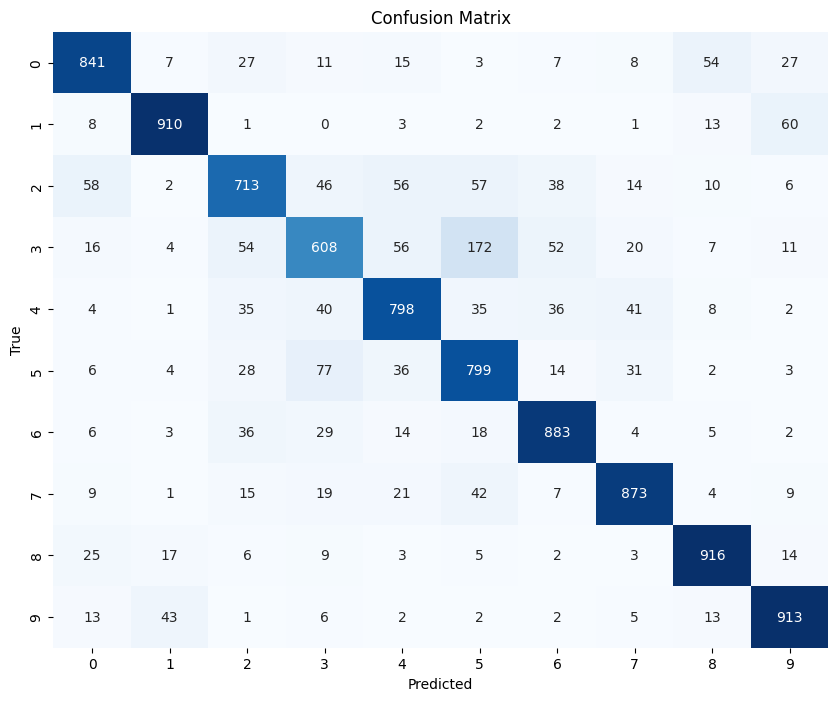

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels to class indices if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test  # If already in class format (sparse)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# If you have class names, you can use them as labels
class_names = list(range(10))
plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names)

plt.show()